# best mask (default density)


All above the max-y regression line:


,mask,opacity,adv_acc,quality,score
0,knit,128,0.3,0.325492,0.025492
1,word,128,0.5,0.533406,0.033406



Max Quality per Accuracy (sorted by final_score):


,mask,opacity,adv_acc,quality,final_score
0,knit,192,0.0,0.097717,0.097717
1,diamond,192,0.1,0.168655,0.068655
3,word,128,0.5,0.533406,0.033406
2,knit,128,0.3,0.325492,0.025492
4,knit,64,0.7,0.601707,-0.098293
5,word,64,0.8,0.668919,-0.131081


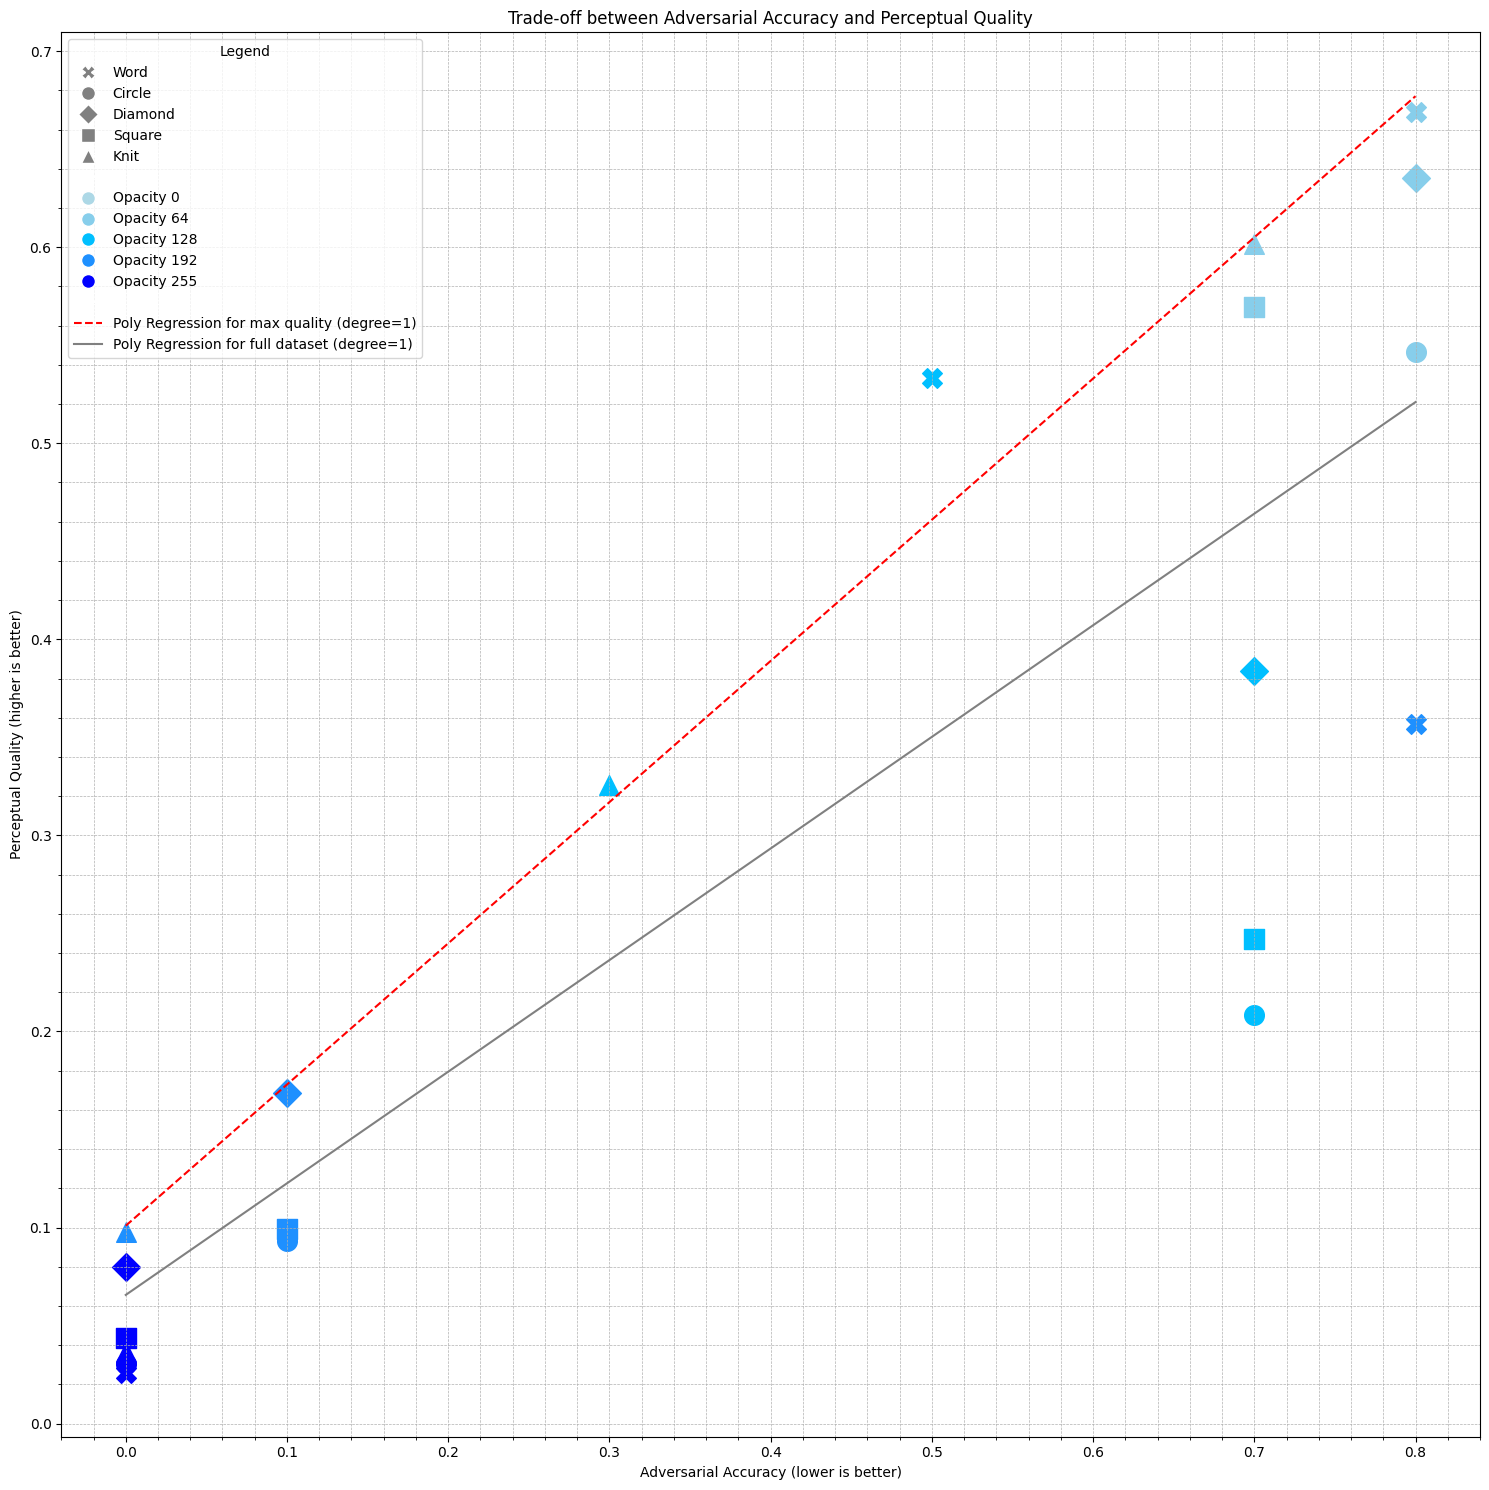

In [3]:
from scipy.optimize import minimize_scalar
from scipy.optimize import fsolve
from scipy import optimize
import numpy as np
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


datapath = Path.cwd().parent / "data" / "eval" / "0-eval_cls_mask.csv"
data = pd.read_csv(datapath)

"""
preprocessing
"""

data = data.replace([np.inf, -np.inf], np.nan).dropna()
keys = ['mask', 'opacity', 'img_id']
data = data.drop_duplicates(subset=keys)

# difference in accuracy between adversarial and benign examples - we want the performance to decrease relative to what it initially was (lower is better)
data['adv_acc'] = ((data['advx_acc1'] + data['advx_acc5']) / 2) - ((data['x_acc1'] + data['x_acc5']) / 2) + 1
# perceptual quality, approximates human perception (higher is better)
data['quality'] = (data['cosine_sim'] + data['psnr'] / 100 + data['ssim']) / 3

# group by mask, opacity - get mean of just the 2 inferred metrics
data = data.groupby(['mask', 'opacity']).agg({
    'adv_acc': 'mean',
    'quality': 'mean',
}).reset_index()

data = data.replace([np.inf, -np.inf], np.nan).dropna()
if np.isinf(data['adv_acc']).any() or np.isinf(data['quality']).any():
    print("\nwarning: Infinity values still present in the data")

"""
scatter plot
"""

markers = {'word': 'X', 'circle': 'o', 'diamond': 'D', 'square': 's', 'knit': '^'}
colors = {0: 'lightblue', 64: 'skyblue', 128: 'deepskyblue', 192: 'dodgerblue', 255: 'blue'}

plt.figure(figsize=(15, 15))

for mask in markers:
    for opacity in colors:
        mask_opacity_data = data[(data['mask'] == mask) & (data['opacity'] == opacity)]
        plt.scatter(mask_opacity_data['adv_acc'], mask_opacity_data['quality'], 
                    marker=markers[mask], c=colors[opacity], s=200,
                    label=f'{mask}, opacity={opacity}')

"""
max y value
"""

x = data['adv_acc']
y = data['quality']

max_coords = []
for x_elem in x:
    y_elem = y[x == x_elem]
    max_y = y_elem.max()
    max_coords.append((x_elem, max_y))
    # plt.scatter(x_elem, max_y, marker='o', facecolors='none', edgecolors='gray', s=3)

max_coords = sorted(max_coords, key=lambda x: x[0])
max_x, max_y = zip(*max_coords)
# plt.plot(max_x, max_y, color='gray', linestyle='--')

max_coords_df = []
for x_elem, y_elem in max_coords:
    max_coords_df.append(data[(data['adv_acc'] == x_elem) & (data['quality'] == y_elem)].iloc[0])
max_coords_df = pd.DataFrame(max_coords_df)
max_coords_df = max_coords_df.drop_duplicates(subset=['mask', 'opacity']).reset_index(drop=True)
max_coords_df['final_score'] = -max_coords_df['adv_acc'] + max_coords_df['quality']

# approximate with a polynomial regression
x = np.array(max_x).reshape(-1, 1)
y = np.array(max_y)
maxy_degree = 1
polyreg = make_pipeline(PolynomialFeatures(maxy_degree), LinearRegression())
polyreg.fit(x, y)
x_smooth = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
y_smooth = polyreg.predict(x_smooth)
plt.plot(x_smooth, y_smooth, color='red', linestyle='--')

print("\nAll above the max-y regression line:")
above = [data[(data['adv_acc'] == x_elem) & (data['quality'] == y_elem)].iloc[0] for x_elem, y_elem in max_coords if y_elem > polyreg.predict([[x_elem]])]
above = pd.DataFrame(above)
above = above.drop_duplicates(subset=['mask', 'opacity']).reset_index(drop=True)
above['score'] = -above['adv_acc'] + above['quality']
display(HTML(above.to_html()))

# print("\nMax Quality per Accuracy (sorted by x coordinate):")
# max_coords_df = max_coords_df.sort_values(by='adv_acc')
# display(HTML(max_coords_df.to_html()))

max_coords_df = max_coords_df.sort_values(by='final_score', ascending=False)
print("\nMax Quality per Accuracy (sorted by final_score):")
display(HTML(max_coords_df.to_html()))

"""
polynomial regression
"""

x = data['adv_acc'].values.reshape(-1, 1)
y = data['quality'].values

total_degree = 1
polyreg = make_pipeline(PolynomialFeatures(total_degree), LinearRegression())
polyreg.fit(x, y)

x_smooth = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
y_smooth = polyreg.predict(x_smooth)

plt.plot(x_smooth, y_smooth, color='gray')

"""
plot
"""

plt.xlabel('Adversarial Accuracy (lower is better)')
plt.ylabel('Perceptual Quality (higher is better)')
plt.title('Trade-off between Adversarial Accuracy and Perceptual Quality')

# legend for markers
legend_elements = [plt.Line2D([0], [0], marker='X', color='w', label='Word', markerfacecolor='gray', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='Circle', markerfacecolor='gray', markersize=10),
                   plt.Line2D([0], [0], marker='D', color='w', label='Diamond', markerfacecolor='gray', markersize=10),
                   plt.Line2D([0], [0], marker='s', color='w', label='Square', markerfacecolor='gray', markersize=10),
                   plt.Line2D([0], [0], marker='^', color='w', label='Knit', markerfacecolor='gray', markersize=10)]

legend_elements.append(plt.Line2D([0], [0], marker='None', color='w', label=''))

# legend for opacity
for opacity, color in colors.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f'Opacity {opacity}', markerfacecolor=color, markersize=10))

legend_elements.append(plt.Line2D([0], [0], marker='None', color='w', label=''))

# legend for max y value
legend_elements.append(plt.Line2D([0], [0], color='red', linestyle='--', label=f'Poly Regression for max quality (degree={maxy_degree})'))

# legend for polynomial regression
legend_elements.append(plt.Line2D([0], [0], color='gray', label=f'Poly Regression for full dataset (degree={total_degree})'))

plt.legend(handles=legend_elements, title='Legend', loc='upper left')

# add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())

plt.tight_layout()
plt.show()


# best mask (variable density)


All above the max-y regression line:


,mask,opacity,density,adv_acc,quality,final_score
0,diamond,128.0,100.0,0.3,0.375241,0.075241
1,diamond,64.0,70.0,0.6,0.660948,0.060948
2,diamond,64.0,80.0,0.7,0.643403,-0.056597
3,diamond,64.0,40.0,0.8,0.648576,-0.151424



Max Quality per Accuracy (sorted by final_score):


,mask,opacity,density,adv_acc,quality,final_score
0,diamond,192.0,70.0,0.0,0.177029,0.177029
1,word,128.0,100.0,0.1,0.183308,0.083308
3,diamond,128.0,100.0,0.3,0.375241,0.075241
6,diamond,64.0,70.0,0.6,0.660948,0.060948
2,circle,128.0,60.0,0.2,0.228500,0.028500
4,square,128.0,90.0,0.4,0.396056,-0.003944
7,diamond,64.0,80.0,0.7,0.643403,-0.056597
5,diamond,128.0,80.0,0.5,0.397741,-0.102259
8,diamond,64.0,40.0,0.8,0.648576,-0.151424
9,knit,64.0,70.0,0.9,0.656039,-0.243961


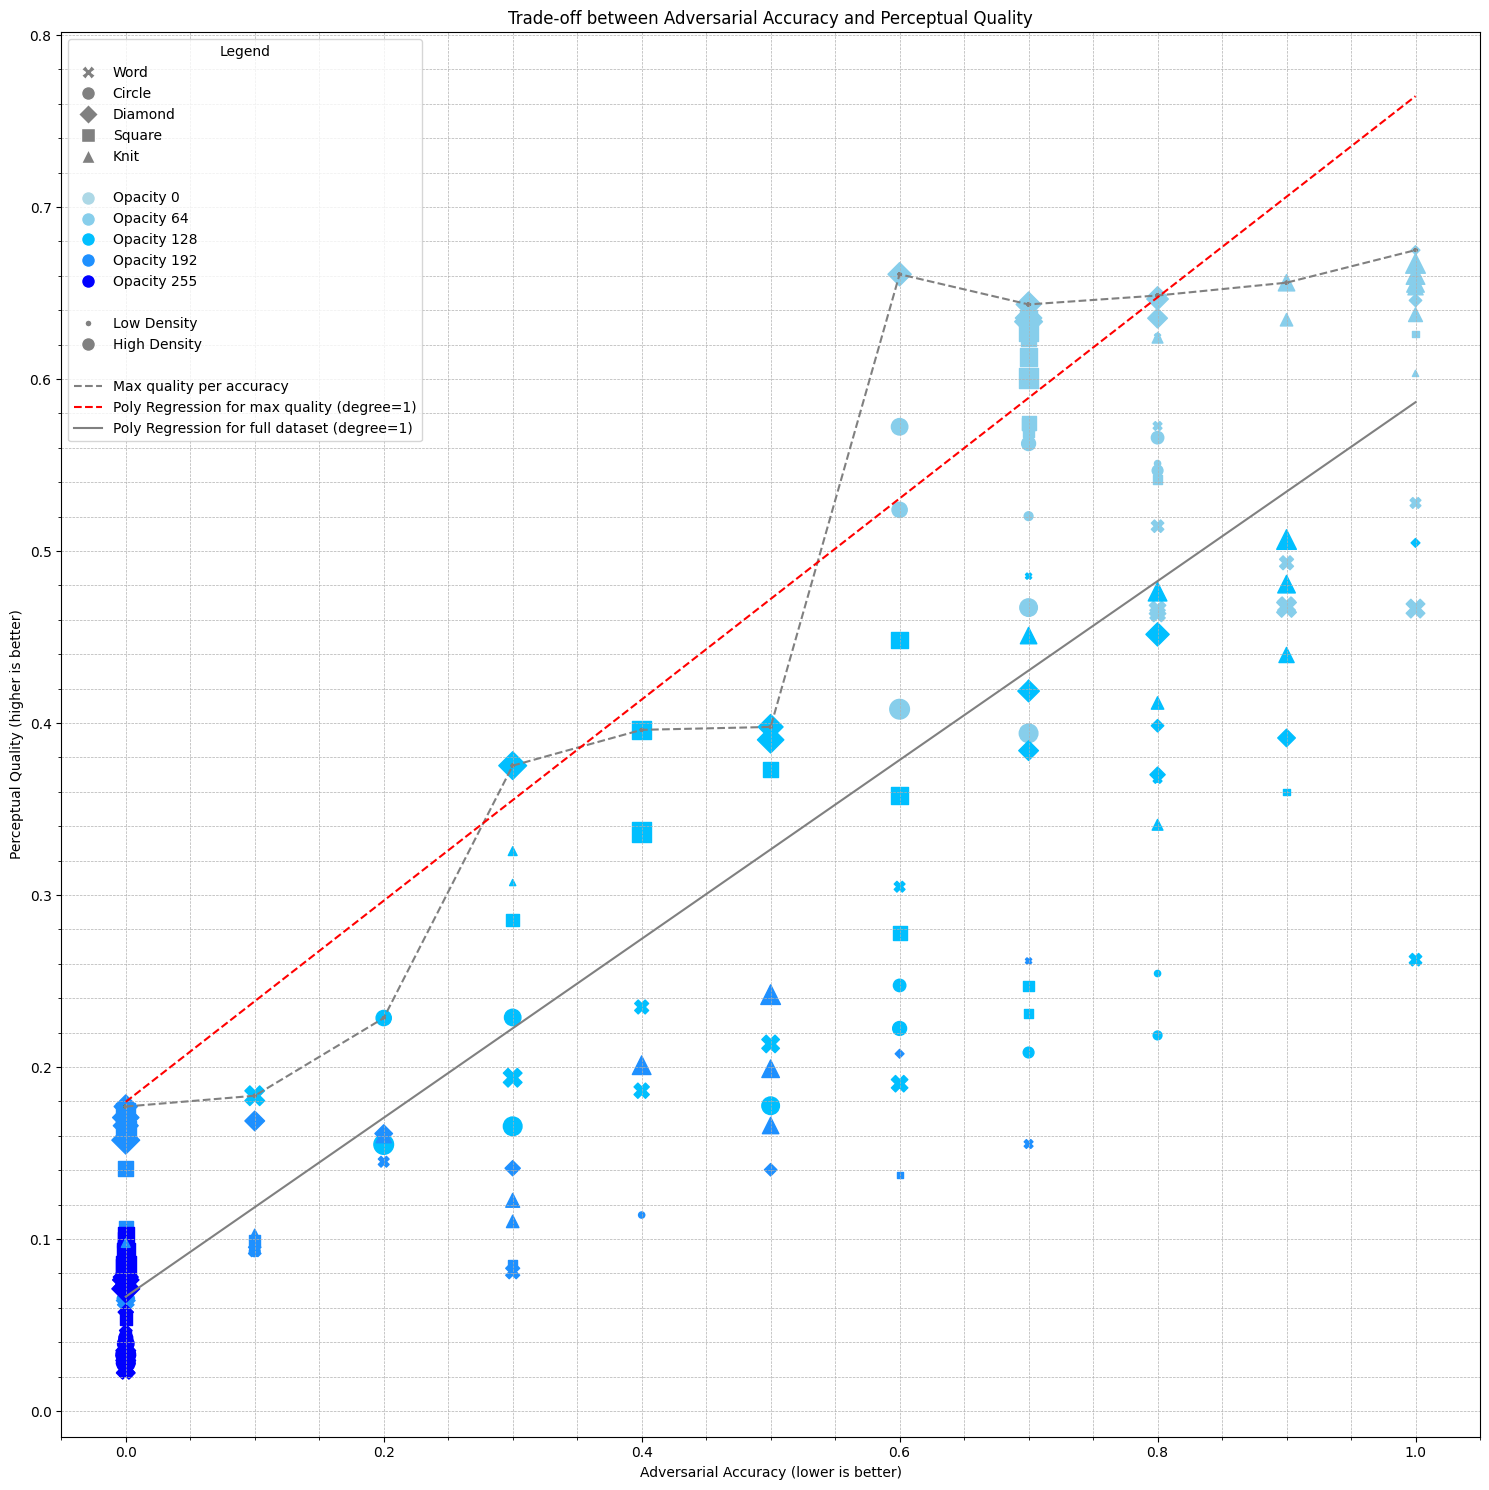

In [2]:
from scipy.optimize import minimize_scalar
from scipy.optimize import fsolve
from scipy import optimize
import numpy as np
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


datapath = Path.cwd().parent / "data" / "eval" / "0-eval_cls_mask_density.csv"
data = pd.read_csv(datapath)

"""
preprocessing
"""

data = data.replace([np.inf, -np.inf], np.nan).dropna()
keys = ['mask', 'opacity', 'density', 'img_id']
data = data.drop_duplicates(subset=keys)

# difference in accuracy between adversarial and benign examples - we want the performance to decrease relative to what it initially was (lower is better)
data['adv_acc'] = ((data['advx_acc1'] + data['advx_acc5']) / 2) - ((data['x_acc1'] + data['x_acc5']) / 2) + 1
# perceptual quality, approximates human perception (higher is better)
data['quality'] = (data['cosine_sim'] + data['psnr'] / 100 + data['ssim']) / 3

# group by mask, opacity, and density - get mean of just the 2 inferred metrics
data = data.groupby(['mask', 'opacity', 'density']).agg({
    'adv_acc': 'mean',
    'quality': 'mean',
}).reset_index()

data = data.replace([np.inf, -np.inf], np.nan).dropna()
if np.isinf(data['adv_acc']).any() or np.isinf(data['quality']).any():
    print("\nwarning: Infinity values still present in the data")

"""
scatter plot
"""

markers = {'word': 'X', 'circle': 'o', 'diamond': 'D', 'square': 's', 'knit': '^'}
colors = {0: 'lightblue', 64: 'skyblue', 128: 'deepskyblue', 192: 'dodgerblue', 255: 'blue'}

plt.figure(figsize=(15, 15))

for mask in markers:
    for opacity in colors:
        mask_opacity_data = data[(data['mask'] == mask) & (data['opacity'] == opacity)]
        plt.scatter(mask_opacity_data['adv_acc'], mask_opacity_data['quality'], 
                    marker=markers[mask], c=colors[opacity], s=mask_opacity_data['density']*2,
                    label=f'{mask}, opacity={opacity}')

"""
max y value
"""

x = data['adv_acc']
y = data['quality']

max_coords = []
for x_elem in x:
    y_elem = y[x == x_elem]
    max_y = y_elem.max()
    max_coords.append((x_elem, max_y))
    plt.scatter(x_elem, max_y, marker='o', facecolors='none', edgecolors='gray', s=3)

max_coords = sorted(max_coords, key=lambda x: x[0])
max_x, max_y = zip(*max_coords)
plt.plot(max_x, max_y, color='gray', linestyle='--')

max_coords_df = []
for x_elem, y_elem in max_coords:
    max_coords_df.append(data[(data['adv_acc'] == x_elem) & (data['quality'] == y_elem)].iloc[0])
max_coords_df = pd.DataFrame(max_coords_df)
max_coords_df = max_coords_df.drop_duplicates(subset=['mask', 'opacity', 'density']).reset_index(drop=True)
max_coords_df['final_score'] = -max_coords_df['adv_acc'] + max_coords_df['quality']

# approximate with a polynomial regression
x = np.array(max_x).reshape(-1, 1)
y = np.array(max_y)
maxy_degree = 1
polyreg = make_pipeline(PolynomialFeatures(maxy_degree), LinearRegression())
polyreg.fit(x, y)
x_smooth = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
y_smooth = polyreg.predict(x_smooth)
plt.plot(x_smooth, y_smooth, color='red', linestyle='--')

print("\nAll above the max-y regression line:")
above = [data[(data['adv_acc'] == x_elem) & (data['quality'] == y_elem)].iloc[0] for x_elem, y_elem in max_coords if y_elem > polyreg.predict([[x_elem]])]
above = pd.DataFrame(above)
above['final_score'] = -above['adv_acc'] + above['quality']
above = above.sort_values(by='final_score', ascending=False)
above = above.drop_duplicates(subset=['mask', 'opacity', 'density']).reset_index(drop=True)
display(HTML(above.to_html()))

# print("\nMax Quality per Accuracy (sorted by x coordinate):")
# max_coords_df = max_coords_df.sort_values(by='adv_acc')
# display(HTML(max_coords_df.to_html()))

print("\nMax Quality per Accuracy (sorted by final_score):")
max_coords_df['final_score'] = -max_coords_df['adv_acc'] + max_coords_df['quality']
max_coords_df = max_coords_df.sort_values(by='final_score', ascending=False)
display(HTML(max_coords_df.to_html()))

# """
# critical point
# """

# # calculate first and second derivatives
# poly_coef = polyreg.named_steps['linearregression'].coef_
# poly_coef = poly_coef[::-1]  # reverse the order of coefficients

# def poly_func(x):
#     return np.polyval(poly_coef, x)

# def first_derivative(x):
#     der_coef = np.polyder(poly_coef)
#     return np.polyval(der_coef, x)

# def second_derivative(x):
#     der_coef = np.polyder(poly_coef, m=2)
#     return np.polyval(der_coef, x)

# # find critical points numerically
# def find_critical_points(func, a, b, n=10):
#     x = np.linspace(a, b, n)
#     critical_points = []
#     for x0 in x:
#         sol = optimize.root(func, x0)
#         if sol.success and a <= sol.x <= b:
#             critical_points.append(sol.x[0])
#     return np.unique(critical_points)

# # critical_points = fsolve(first_derivative, x_smooth.mean())
# critical_points = find_critical_points(first_derivative, x_smooth.min(), x_smooth.max())

# def curvature(x):
#     return np.abs(second_derivative(x)) / (1 + first_derivative(x)**2)**1.5

# # find point of maximum curvature numerically
# result = minimize_scalar(lambda x: -curvature(x), bounds=(x_smooth.min(), x_smooth.max()), method='bounded')
# critical_x = result.x
# critical_y = poly_func(critical_x)

# data['distance_to_critical'] = np.abs(data['adv_acc'] - critical_x) + np.abs(data['quality'] - critical_y)
# closest = data.loc[data['distance_to_critical'].idxmin()]
# # empty circle
# plt.scatter(critical_x, critical_y, marker='o', facecolors='none', edgecolors='pink', s=3_000)

# print("\nClosest to Critical Point:")
# closest = data.sort_values(by='distance_to_critical')
# display(HTML(closest.head(10).to_html()))

"""
polynomial regression
"""

x = data['adv_acc'].values.reshape(-1, 1)
y = data['quality'].values

total_degree = 1
polyreg = make_pipeline(PolynomialFeatures(total_degree), LinearRegression())
polyreg.fit(x, y)

x_smooth = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
y_smooth = polyreg.predict(x_smooth)

plt.plot(x_smooth, y_smooth, color='gray')

"""
plot
"""

plt.xlabel('Adversarial Accuracy (lower is better)')
plt.ylabel('Perceptual Quality (higher is better)')
plt.title('Trade-off between Adversarial Accuracy and Perceptual Quality')

# legend for markers
legend_elements = [plt.Line2D([0], [0], marker='X', color='w', label='Word', markerfacecolor='gray', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='Circle', markerfacecolor='gray', markersize=10),
                   plt.Line2D([0], [0], marker='D', color='w', label='Diamond', markerfacecolor='gray', markersize=10),
                   plt.Line2D([0], [0], marker='s', color='w', label='Square', markerfacecolor='gray', markersize=10),
                   plt.Line2D([0], [0], marker='^', color='w', label='Knit', markerfacecolor='gray', markersize=10)]

legend_elements.append(plt.Line2D([0], [0], marker='None', color='w', label=''))

# legend for opacity
for opacity, color in colors.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f'Opacity {opacity}', markerfacecolor=color, markersize=10))

legend_elements.append(plt.Line2D([0], [0], marker='None', color='w', label=''))

# legend for density
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Low Density', markerfacecolor='gray', markersize=5))
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='High Density', markerfacecolor='gray', markersize=10))

legend_elements.append(plt.Line2D([0], [0], marker='None', color='w', label=''))

# legend for max y value
legend_elements.append(plt.Line2D([0], [0], color='gray', linestyle='--', label=f'Max quality per accuracy'))
legend_elements.append(plt.Line2D([0], [0], color='red', linestyle='--', label=f'Poly Regression for max quality (degree={maxy_degree})'))

# legend for polynomial regression
legend_elements.append(plt.Line2D([0], [0], color='gray', label=f'Poly Regression for full dataset (degree={total_degree})'))

plt.legend(handles=legend_elements, title='Legend', loc='upper left')

# add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())

plt.tight_layout()
plt.show()


# conclusion

- high perceptual quality == low opacity, high density
    - optimal opacity seems to be in \[50;200]
    - higher density seems to be better
- diamond mask seems to offer the best bang for the buck in many cases (only use diamond mask in the next steps)